# Parte 2 - Modelo de Cantidad Vendida

En este Notebook se desarrollará el Análisis Exploratorio para la creación de un modelo que permita predecir la cantidad vendida, *sold_quantity*, de un producto basado en sus características.

## 1. Carga de Datos

Se realizará la carga de datos como se describió en la Parte 1. Se tiene información de hasta 10.000 productos por cada categoría (31 en total) a corte del 24 de diciembre de 2020. En total se registra información de 271.082 productos entre las 31 categorías.

En este cargue se incluye como pre-procesamiento la construcción de las variables utilizadas para el Análisis Exploratorio de productos con descuento.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import  matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(10, 5)})

In [3]:
data_folder = '../data'
data_by_category = [pd.read_csv(os.path.join(data_folder, file), sep = ";") for file in os.listdir('../data') if file.find('.csv') != -1]
complete_df = pd.concat(data_by_category, axis = 0, ignore_index=True)
complete_df['has_discount'] = ~complete_df.original_price.isnull()

In [60]:
complete_df.columns

Index(['id', 'title', 'price', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'condition', 'accepts_mercadopago',
       'original_price', 'category_id', 'seller_level_id',
       'seller_powerseller', 'positive_rating', 'negative_rating',
       'neutral_rating', 'free_shipping', 'store_pickup', 'number_of_tags',
       'is_official_store', 'month_update', 'year_update', 'year_created',
       'month_created', 'total_questions', 'category_name', 'has_discount',
       'vlr_descuento', 'product_age', 'GroupedReputation'],
      dtype='object')

In [11]:
# Cálculo del descuento aplicado al producto
complete_df.loc[complete_df.original_price.isnull(), 'vlr_descuento'] = 0
complete_df.loc[~complete_df.original_price.isnull(), 'vlr_descuento'] = round(1 - complete_df['price']/complete_df['original_price'], 2)

In [7]:
# Construcción de un indicador de antigüedad en meses. 
actual_year = 2020
actual_month = 12
complete_df['product_age'] = 12*(actual_year - complete_df.year_created) + (actual_month - complete_df.month_created) + 1

In [9]:
# Modificadores de Reputación
complete_df.loc[complete_df.seller_powerseller.isna(), 'seller_powerseller'] = 'NotPowerSeller'

complete_df.loc[complete_df.seller_level_id.isnull(), 'seller_level_id'] = 'NoColor'
complete_df.loc[complete_df.seller_level_id.isin(['5_green', '4_light_green']), 'GroupedReputation'] = 'Green Seller'
complete_df.loc[complete_df.seller_level_id.isin(['2_orange', '1_red']), 'GroupedReputation'] = 'Orange Seller'
complete_df.loc[complete_df.seller_level_id == '3_yellow', 'GroupedReputation'] = 'Yellow Seller'
complete_df.loc[complete_df.seller_level_id == 'NoColor', 'GroupedReputation'] = 'No Color'

## 2. Análisis Exploratorio

La variable de interés *sold_quantity*, corresponde a una variable categórica que define rangos para una variable latente de cantidad vendida. Dependiendo del valor real de cantidad que se ha vendido de un producto (Dato Real), la variable se codifica como aparece en Referencia, de acuerdo con la siguiente tabla:

| Dato Real | Referencia   |
|------|------|
|1|1|
|2|2|
|3|3|
|4|4|
|5|5|
|RANGO_6_25|5|
|RANGO_26_50|25|
|RANGO_51_100|50|
|RANGO_101_150|100|
|RANGO_151_200|150|
|RANGO_201_250|200|
|RANGO_251_500|250|
|RANGO_501_5000|500|
|RANGO_5001_50000|5000|
|RANGO_50001_500000|50000|
[Fuente.](https://developers.mercadolibre.com.co/es_ar/items-y-busquedas)

A continuación se observa la distribución de las categorías de cantidades vendidas (*sold_quantity*). Es posible observar que es un conjunto de datos que NO está balanceado. Hay baja representación ventas de 5001-50.000 y no hay representación de ventas superiores a 50.001 unidades. De esta forma, el modelo que se obtenga como resultado deberá ser evaluado teniendo en cuenta lo anterior, y no será capaz de predecir ventas de productos superiores a 50.000 unidades. 


In [19]:
complete_df.sold_quantity.value_counts()

5       79450
0       51855
1       28019
25      27625
50      20590
2       16096
3       11504
4        9616
100      8706
250      5892
150      4597
500      4119
200      2926
5000       87
Name: sold_quantity, dtype: int64

### 2.1 Antigüedad y Preguntas

Debido a que se va a analizar la variable de total de unidades vendidas (sold quantity) y esta es una variable de stock, se espera que entre más antiguo sea un producto en el Marketplace, mayor será la cantidad vendida de este. El siguiente gráfico muestra la distribución de la antigüedad condicional al total de unidades vendidas. En él se puede apreciar que los productos con menos de 5 unidades vendidas tienen, en su mayoría, menos de 2 años en el Marketplace. En contraste, los productos con una mayor cantidad de unidades vendidas tienen significativamente más tiempo de ser publicados.

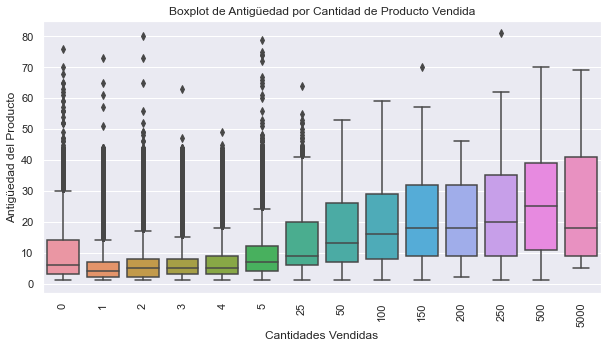

In [21]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="product_age", data=complete_df)
plt.title('Boxplot de Antigüedad por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Antigüedad del Producto')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

(0.0, 4000.0)

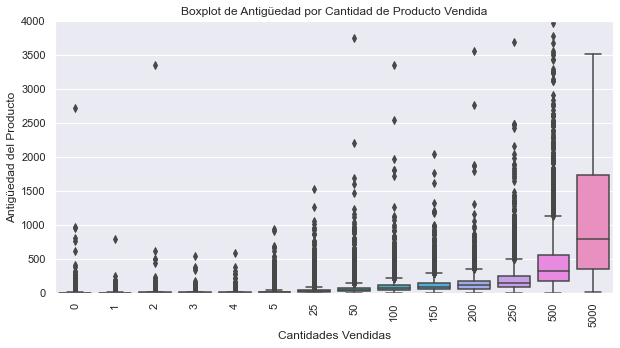

In [66]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="total_questions", data=complete_df[complete_df.total_questions > 0])
plt.title('Boxplot de Antigüedad por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Antigüedad del Producto')
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim((0, 4000))

# Hagamos un PCA de cantidad de preguntas y antiguedad, para ver cómo se relaciona
# O mejor un scatterplot de preguntas con atiguedad y colorear por categoria

### 2.2. Cantidad Disponible

En principio, la cantidad vendida de un producto podría identificarse utilizando información de la cantidad disponible para la venta y el total de unidades disponibles en publicación. Sin embargo, sólo se cuenta con información de las cantidades disponibles. Esta variable se encuentra discretizada de acuerdo a la siguiente tabla:

| Dato Real | Referencia   |
|------|------|
|RANGO_0_50|1|
|RANGO_51_100|50|
|RANGO_101_150|100|
|RANGO_151_200|150|
|RANGO_201_250|200|
|RANGO_251_500|250|
|RANGO_501_5000|500|
|RANGO_5001_50000|5000|
|RANGO_50001_99999|50000|
[Fuente.](https://developers.mercadolibre.com.co/es_ar/items-y-busquedas)


A continuación realizamos un gráfico de barras para determinar si existen concentraciones diferenciadas por categoría de cantidad vendida. 

<Figure size 720x720 with 0 Axes>

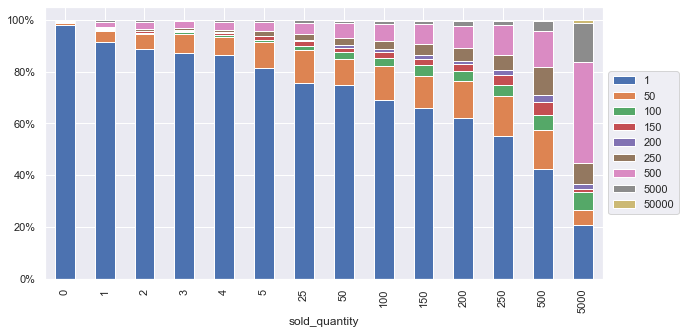

In [83]:
# Necesito hacer concentraciones por cantidades disponibles. 
#plt.figure(figsize = (20, 10))
#occupation_counts = (complete_df.groupby(['sold_quantity'])['available_quantity']
#                     .value_counts(normalize=True)
#                     .rename('percentage')
#                     .mul(100)
#                     .reset_index()
#                     .sort_values('sold_quantity'))
#p = sns.barplot(x="sold_quantity", y="percentage", hue="available_quantity", data=occupation_counts)
#_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels


#ax = sns.countplot(x="available_quantity", hue="sold_quantity", data=complete_df)




plt.figure(figsize = (10, 10))
complete_df.groupby(['sold_quantity','available_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Se puede observar que la categoría de cantidad disponible 1 (de 0 a 50 unidades disponibles) presenta la mayor concentración para cantidades vendidas de 501-5000 unidades. Sin embargo, para productos con entre 5.000 y 50.000 unidades vendidas, las cantidades disponibles se concentran, en su mayoría, en 500 (501-5.000 unidades disponibles).

Este resultado indica que la variable de cantidades disponibles no es informativa para productos con unidades vendidas de hasta rango 500-5.000.



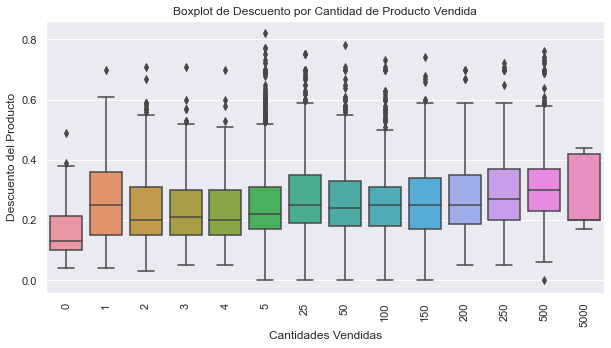

In [34]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="vlr_descuento", data=complete_df[complete_df.has_discount])
plt.title('Boxplot de Descuento por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Descuento del Producto')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

En el siguiente gráfico se puede apreciar que hay categorías de productos que la totalidad de productos que han vendido es 0. Estos son:
- Servicios
- Inmuebles
- Carros, Motos y Otros

Adicionalmente, se puede observar que la categoría de cantidad vendida con mayor representación dentro de las categorías de producto es ventas de 5 - 25 unidades. 

<Figure size 720x720 with 0 Axes>

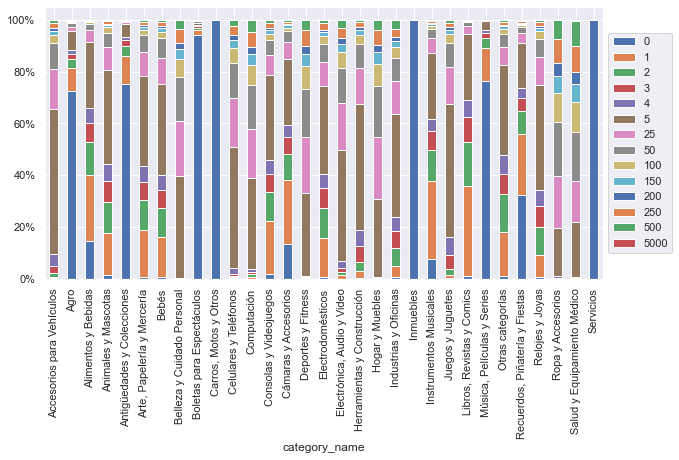

In [54]:

plt.figure(figsize = (10, 10))
complete_df.groupby(['category_name','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

<Figure size 720x720 with 0 Axes>

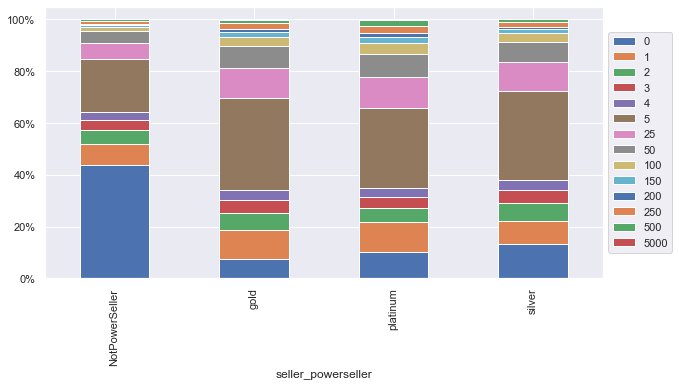

In [56]:

plt.figure(figsize = (10, 10))
complete_df.groupby(['seller_powerseller','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

<Figure size 720x720 with 0 Axes>

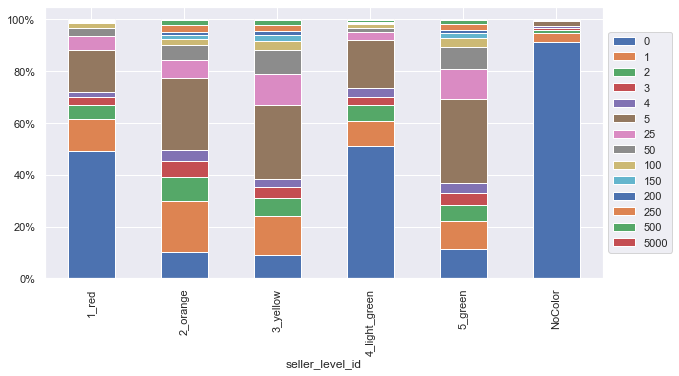

In [57]:

plt.figure(figsize = (10, 10))
complete_df.groupby(['seller_level_id','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

<Figure size 720x720 with 0 Axes>

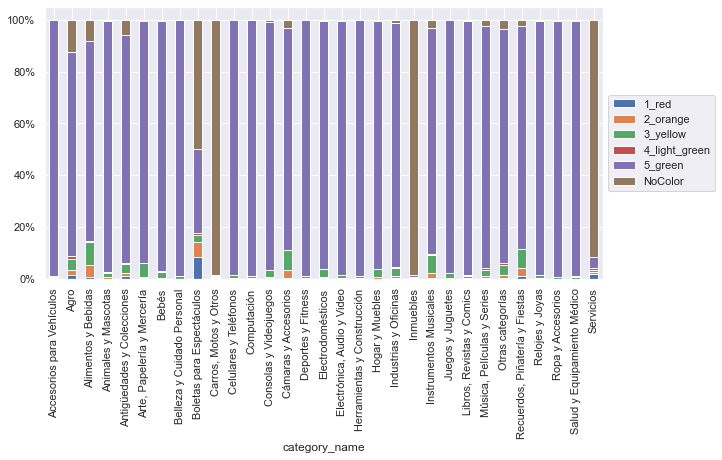

In [59]:
# Ush, este gráfico muestra que las tres categorías que apenas tienen ventas, 
#casi siempre son comercializadas por individuos que no tienen suficientes ventas.
# El resto de productos es comercializado, en su mayoría, por individuos de excelente reputación. 
plt.figure(figsize = (10, 10))
complete_df.groupby(['category_name','seller_level_id']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [69]:
complete_df[(complete_df.year_update == complete_df.year_created) & (complete_df.month_update == complete_df.month_created)]

,id,title,price,available_quantity,sold_quantity,buying_mode,listing_type_id,condition,accepts_mercadopago,original_price,...,month_update,year_update,year_created,month_created,total_questions,category_name,has_discount,vlr_descuento,product_age,GroupedReputation
2,MCO572050868,Kit Micrófono Solapa Housailei Con Accesorios ...,48000.0,1,500,buy_it_now,gold_pro,new,True,NaN,...,7,2020,2020.0,7.0,618.0,"Electrónica, Audio y Video",False,0.00,6.0,Green Seller
3,MCO581978067,Micrófono De Solapa Profesional Housailei Con ...,47900.0,50,500,buy_it_now,gold_pro,new,True,NaN,...,9,2020,2020.0,9.0,227.0,"Electrónica, Audio y Video",False,0.00,4.0,Green Seller
5,MCO559560948,Audífonos Bluetooth Inalámbricos Tedge,64900.0,150,250,buy_it_now,gold_special,new,True,99900.0,...,9,2020,2020.0,9.0,150.0,"Electrónica, Audio y Video",True,0.35,4.0,Green Seller
11,MCO558809626,Audifonos Haylou Gt1 Pro Touch Inalambricos Bl...,102999.0,50,500,buy_it_now,gold_special,new,True,NaN,...,4,2020,2020.0,4.0,390.0,"Electrónica, Audio y Video",False,0.00,9.0,Green Seller
12,MCO574370817,Funda Forro Protector Silicona Control Magic LG,16900.0,250,500,buy_it_now,gold_special,new,True,22900.0,...,8,2020,2020.0,8.0,398.0,"Electrónica, Audio y Video",True,0.26,5.0,Green Seller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252518,MCO551763997,Pcs Anillos De Nariz L Acero Quirúrgico Aro De...,87900.0,1,1,buy_it_now,gold_special,new,True,NaN,...,2,2020,2020.0,2.0,7.0,Relojes y Joyas,False,0.00,11.0,Green Seller
252527,MCO560909818,Cadena Tejido Cartier En Plata 925 Italy 00420,179999.0,1,2,buy_it_now,gold_pro,new,True,NaN,...,5,2020,2020.0,5.0,8.0,Relojes y Joyas,False,0.00,8.0,Green Seller
252532,MCO471555644,Aretes De Mariquita Topitos Niña Aretes Delica...,5200.0,1,5,buy_it_now,gold_pro,new,True,NaN,...,5,2018,2018.0,5.0,4.0,Relojes y Joyas,False,0.00,32.0,Green Seller
252551,MCO594920483,Reloj Inteligente Smart Watch T500 Serie 5,94900.0,1,5,buy_it_now,gold_pro,new,True,NaN,...,11,2020,2020.0,11.0,32.0,Relojes y Joyas,False,0.00,2.0,Yellow Seller


Yo creo que lo anterior nos está mostrando que las relaciones entre las variables que tenemos disponibles y las cantidades vendidas son no lineales. 

## 3. Benchmark

Con findes de comparación, se creará un modelo base utilizando la información descubierta hasta el momento. En principio, un producto de 

puede ser que ponga la moda de la categoría por antiguedad en el train. 